<a id='top'></a>

# Data Parsing of Wyscout Event Data
##### Notebook to parse JSON data from [Wyscout](https://wyscout.com/)  to create one unified Events DataFrame.

### By [Edd Webster](https://www.twitter.com/eddwebster)
Notebook first written: 26/01/2021<br>
Notebook last updated: 12/02/2021

![title](../../img/logos/wyscout_logo.png)

Click [here](#section5) to jump straight to the Exploratory Data Analysis section and skip the [Task Brief](#section2), [Data Sources](#section3), and [Data Engineering](#section4) sections. Or click [here](#section6) to jump straight to the Conclusion.

---

## <a id='import_libraries'>Introduction</a>
This notebook parses pubicly available [Wyscout](https://wyscout.com/) Event data for the 'Big 5' European leagues for the 17/18 mens season, the 2016 European Championship, and the 2018 FIFA Mens World Cup, using [pandas](http://pandas.pydata.org/) for data manipulation through DataFrames.

For more information about this notebook and the author, I'm available through all the following channels:
*    [eddwebster.com](https://www.eddwebster.com/);
*    edd.j.webster@gmail.com;
*    [@eddwebster](https://www.twitter.com/eddwebster);
*    [linkedin.com/in/eddwebster](https://www.linkedin.com/in/eddwebster/);
*    [github/eddwebster](https://github.com/eddwebster/);
*    [public.tableau.com/profile/edd.webster](https://public.tableau.com/profile/edd.webster);
*    [kaggle.com/eddwebster](https://www.kaggle.com/eddwebster); and
*    [hackerrank.com/eddwebster](https://www.hackerrank.com/eddwebster).

![title](../../img/edd_webster/fifa21eddwebsterbanner.png)

The accompanying GitHub repository for this notebook can be found [here](https://github.com/eddwebster/football_analytics) and a static version of this notebook can be found [here](https://nbviewer.jupyter.org/github/eddwebster/football_analytics/blob/master/notebooks/2_data_parsing/Wyscout%20Parsing.ipynb).

___

## <a id='notebook_contents'>Notebook Contents</a>
1.    [Notebook Dependencies](#section1)<br>
2.    [Project Brief](#section2)<br>
3.    [Data Sources](#section3)<br>
      1.    [Introduction](#section3.1)<br>
      2.    [Download the Data](#section3.2)<br>
      3.    [Read in the Datasets](#section3.3)<br>
      4.    [Join the Datasets](#section3.4)<br>
      5.    [Initial Data Handling](#section3.5)<br>
4.    [Data Engineering](#section4)<br>
      1.    [Sort the DataFrame](#section4.1)<br>
5.    [Export DataFrame](#section5)<br>
6.    [Summary](#section6)<br>
7.    [Next Steps](#section7)<br>
8.    [Bibliography](#section8)<br>

---

## <a id='#section1'>1. Notebook Dependencies</a>

This notebook was written using [Python 3](https://docs.python.org/3.7/) and requires the following libraries:
*    [`Jupyter notebooks`](https://jupyter.org/) for this notebook environment with which this project is presented;
*    [`NumPy`](http://www.numpy.org/) for multidimensional array computing;
*    [`pandas`](http://pandas.pydata.org/) for data analysis and manipulation; and
*    `tqdm` for a clean progress bar;

All packages used for this notebook except for BeautifulSoup can be obtained by downloading and installing the [Conda](https://anaconda.org/anaconda/conda) distribution, available on all platforms (Windows, Linux and Mac OSX). Step-by-step guides on how to install Anaconda can be found for Windows [here](https://medium.com/@GalarnykMichael/install-python-on-windows-anaconda-c63c7c3d1444) and Mac [here](https://medium.com/@GalarnykMichael/install-python-on-mac-anaconda-ccd9f2014072), as well as in the Anaconda documentation itself [here](https://docs.anaconda.com/anaconda/install/).

### Import Libraries and Modules

In [1]:
%load_ext autoreload
%autoreload 2

# Python ≥3.5 (ideally)
import platform
import sys, getopt
assert sys.version_info >= (3, 5)
import csv

# Import Dependencies
%matplotlib inline

# Math Operations
import numpy as np
import math
from math import pi

# Datetime
import datetime
from datetime import date
import time

# Data Preprocessing
import pandas as pd
import os
import re
import random
from io import BytesIO
from pathlib import Path

# Reading directories
import glob
import os
from os.path import basename

# Working with JSON
import json
from pandas.io.json import json_normalize

# Data Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib.patches import Arc
import seaborn as sns
plt.style.use('seaborn-whitegrid')
import missingno as msno

# Downloading data sources
from urllib.parse import urlparse
from urllib.request import urlopen, urlretrieve
from zipfile import ZipFile, is_zipfile
from tqdm import tqdm    # Progress Bar

# Display in Jupyter
from IPython.display import Image, Video, YouTubeVideo
from IPython.core.display import HTML

# Ignore Warnings
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

print('Setup Complete')

Setup Complete


In [2]:
# Python / module versions used here for reference
print('Python: {}'.format(platform.python_version()))
print('NumPy: {}'.format(np.__version__))
print('pandas: {}'.format(pd.__version__))
print('matplotlib: {}'.format(mpl.__version__))
print('Seaborn: {}'.format(sns.__version__))

Python: 3.7.6
NumPy: 1.18.0
pandas: 1.2.0
matplotlib: 3.3.2
Seaborn: 0.11.1


### Defined Variables

In [3]:
# Define today's date
today = datetime.datetime.now().strftime('%d/%m/%Y').replace('/', '')

### Defined Filepaths

In [4]:
# Set up initial paths to subfolders
base_dir = os.path.join('..', '..',)
data_dir = os.path.join(base_dir, 'data')
data_dir_wyscout = os.path.join(base_dir, 'data', 'wyscout')
scripts_dir = os.path.join(base_dir, 'scripts')
scripts_dir_wyscout = os.path.join(base_dir, 'scripts', 'wyscout')
img_dir = os.path.join(base_dir, 'img')
fig_dir = os.path.join(base_dir, 'img', 'fig')
fig_dir_wyscout = os.path.join(base_dir, 'img', 'fig', 'wyscout')
video_dir = os.path.join(base_dir, 'video')

### Custom Functions

In [5]:
# Define custom function to read JSON files that also handles the encoding of special characters e.g. accents in names of players and teams
def read_json_file(filename):
    with open(filename, 'rb') as json_file:
        return BytesIO(json_file.read()).getvalue().decode('unicode_escape')
    
# Define custom function to flatten pandas DataFrames with nested JSON columns. Source: https://stackoverflow.com/questions/39899005/how-to-flatten-a-pandas-dataframe-with-some-columns-as-json
def flatten_nested_json_df(df):

    df = df.reset_index()

    print(f"original shape: {df.shape}")
    print(f"original columns: {df.columns}")


    # search for columns to explode/flatten
    s = (df.applymap(type) == list).all()
    list_columns = s[s].index.tolist()

    s = (df.applymap(type) == dict).all()
    dict_columns = s[s].index.tolist()

    print(f"lists: {list_columns}, dicts: {dict_columns}")
    while len(list_columns) > 0 or len(dict_columns) > 0:
        new_columns = []

        for col in dict_columns:
            print(f"flattening: {col}")
            # explode dictionaries horizontally, adding new columns
            horiz_exploded = pd.json_normalize(df[col]).add_prefix(f'{col}.')
            horiz_exploded.index = df.index
            df = pd.concat([df, horiz_exploded], axis=1).drop(columns=[col])
            new_columns.extend(horiz_exploded.columns) # inplace

        for col in list_columns:
            print(f"exploding: {col}")
            # explode lists vertically, adding new columns
            df = df.drop(columns=[col]).join(df[col].explode().to_frame())
            new_columns.append(col)

        # check if there are still dict o list fields to flatten
        s = (df[new_columns].applymap(type) == list).all()
        list_columns = s[s].index.tolist()

        s = (df[new_columns].applymap(type) == dict).all()
        dict_columns = s[s].index.tolist()

        print(f"lists: {list_columns}, dicts: {dict_columns}")

    print(f"final shape: {df.shape}")
    print(f"final columns: {df.columns}")
    return df

### Notebook Settings

In [6]:
# Display all DataFrame columns
pd.set_option('display.max_columns', None)

---

## <a id='#section2'>2. Project Brief</a>
This Jupyter notebook explores how to parse pubicly available [Wyscout](https://wyscout.com/) JSON data of football matches for the Big 5 European leagues for the 17/18 season using [pandas](http://pandas.pydata.org/) for data manipulation through DataFrames.

The resulting five engineered DataFrames for each of the Big 5 European league are exported to CSV files. This data can be further analysed in Python, joined to other datasets, or explored using Tableau, PowerBI, Microsoft Excel.

**Notebook Conventions**:<br>
*    Variables that refer a `DataFrame` object are prefixed with `df_`.
*    Variables that refer to a collection of `DataFrame` objects (e.g., a list, a set or a dict) are prefixed with `dfs_`.

**References**:<br>
This notebook uses Wyscout data, made publicly available in the following paper by Luca Pappalardo, Paolo Cintia, Alessio Rossi, Emanuele Massucco, Paolo Ferragina, Dino Pedreschi, and Fosca Giannotti. **[A Public Data Set of Spatio-Temporal Match Events in Soccer Competitions](https://www.nature.com/articles/s41597-019-0247-7)**. In *Scientific Data 6*, no. 1 (2019): 1-15.

---

## <a id='#section3'>3. Data Sources</a>

### <a id='#section3.1'>3.1. Introduction</a>

#### <a id='#section3.1.1'>3.1.1. About Wyscout</a>
[Wyscout](https://wyscout.com/) is an Italian company that supports football scouting, match analysis and transfer dynamics. The company was founded in Genoa, Italy in 2004 and provides video analysis tools and digital databases regarding performances and matches for coaches, teams and players dealing with football business.

![title](../../img/wyscout_logo.png)

The purpose is to allow them have a detailed sight of a large number of athletes about individual performances, patterns of play and tactical strategy.

This notebook explores a complete dataset of event data for the Big 5 European leagues during the 17/18 season.

#### <a id='#section3.1.2'>3.1.2. About the Wyscout publicly available data</a>
A detailed description of the data can be found in the following paper:
- Pappalardo, L., Cintia, P., Rossi, A. et al. **A public data set of spatio-temporal match events in soccer competitions**. Scientific Data 6, 236 (2019) doi:10.1038/s41597-019-0247-7, https://www.nature.com/articles/s41597-019-0247-7

It is from this paper import the *matches*, *events*, *players*, *playerank*, *referees*, *coaches*, and *competition* data sets from the <a href="https://doi.org/10.6084/m9.figshare.c.4415000.v5">figshare repository</a>. Data are stored in the `JSON` format. 

The complete data set contains:
- 1,941 matches
- 3,251,294 events
- 4,299 players.

The datasets we will be using are:
- competitions;
- events;
- matches;
- players; and
- teams

The data needs to be imported as a DataFrame in the Data Sources section [Section 3](#section3) and cleaned in the Data Engineering section [Section 4](#section4).

### <a id='#section3.2'>3.2. Download the Data</a>
This section downloads the Wyscout datasets if not already present in the data folder.

The following `data_files` dictionary lists the four data files in the Wyscout dataset:
*    `events` (73.74 MB): match events for the matches in the dataset;
*    `matches` (629.98 kB): overview of the matches in the dataset;
*    `players` (1.66 MB): information on the players in the dataset;
*    `teams` (26.76 kB): information on the teams in the dataset.

In [7]:
# Define dict in Python where the keys are the names of the files and the values are the corresponding URLs
data_files = {'events': 'https://ndownloader.figshare.com/files/14464685',     # ZIP file containing one JSON file for each competition
              'matches': 'https://ndownloader.figshare.com/files/14464622',    # ZIP file containing one JSON file for each competition
              'players': 'https://ndownloader.figshare.com/files/15073721',    # JSON file
              'teams': 'https://ndownloader.figshare.com/files/15073697'       # JSON file
             }

The following cell loops through the `data_files` dictionary, downloads each listed data file if it is not already present in the directory, and stores each downloaded data file to the local file system.

If the downloaded data file is a ZIP archive, the included JSON files are extracted from the ZIP archive and stored to the local file system.

In [8]:
# Download the listed data files for events, matches, players, and teams
if not os.path.exists(data_dir_wyscout + '/raw/json/'):
    for url in tqdm(data_files.values()):
        url_s3 = urlopen(url).geturl()
        path = Path(urlparse(url_s3).path)
        file_name = path.name
        file_local, _ = urlretrieve(url_s3, file_name)
        if is_zipfile(file_local):
            with ZipFile(file_local) as zip_file:
                zip_file.extractall()
else:
    pass    

### <a id='#section3.3'>3.3. Read in Data</a>
The following cells read the the `JSON` files into a `DataFrame` object with some basic Data Engineering to flatten the data and select only the columns of interest.

####  <a id='#section3.3.1.'>3.3.1. Teams</a>

##### Data dictionary
The [Wyscout](https://wyscout.com/) Events dataset has twelve features (columns) with the following definitions and data types:

| Feature     | Data type    |
|------|-----|
| `eventId`    | int64     |
| `subEventName`    | object     |
| `tags`    | object     |
| `playerId`    | int64     |
| `positions`    | object     |
| `matchId`    | int64     |
| `eventName`    | object     |
| `teamId`    | int64     |
| `matchPeriod`    | object     |
| `eventSec`    | float64     |
| `subEventId`    | object     |
| `id`    | int64     |

Refer to the Wyscout [API docs](https://apidocs.wyscout.com/) and [Events Manual](https://footballdata.wyscout.com/wp-content/uploads/2018/03/Wyscout-Events-Manual.pdf) for further information about event and subevents.

##### Read in JSON file

In [9]:
# Read JSON file as a JSON string and create a pandas DataFrame form the resulting JSON string
json_teams = read_json_file(data_dir_wyscout + '/raw/json/' + 'teams.json')
df_teams = pd.read_json(json_teams)

# Display DataFrame
df_teams.head()

,city,name,wyId,officialName,area,type
0,Newcastle upon Tyne,Newcastle United,1613,Newcastle United FC,"{'name': 'England', 'id': '0', 'alpha3code': '...",club
1,Vigo,Celta de Vigo,692,Real Club Celta de Vigo,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
2,Barcelona,Espanyol,691,Reial Club Deportiu Espanyol,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
3,Vitoria-Gasteiz,Deportivo Alavés,696,Deportivo Alavés,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
4,Valencia,Levante,695,Levante UD,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club


In [10]:
df_teams.shape

(142, 6)

##### Normalise nested columns

In [11]:
# Flatten the nested dictionaries
df_teams_flat = flatten_nested_json_df(df_teams)

# Display DataFrame
df_teams_flat.head()

original shape: (142, 7)
original columns: Index(['index', 'city', 'name', 'wyId', 'officialName', 'area', 'type'], dtype='object')
lists: [], dicts: ['area']
flattening: area
lists: [], dicts: []
final shape: (142, 10)
final columns: Index(['index', 'city', 'name', 'wyId', 'officialName', 'type', 'area.name',
       'area.id', 'area.alpha3code', 'area.alpha2code'],
      dtype='object')


,index,city,name,wyId,officialName,type,area.name,area.id,area.alpha3code,area.alpha2code
0,0,Newcastle upon Tyne,Newcastle United,1613,Newcastle United FC,club,England,0,XEN,
1,1,Vigo,Celta de Vigo,692,Real Club Celta de Vigo,club,Spain,724,ESP,ES
2,2,Barcelona,Espanyol,691,Reial Club Deportiu Espanyol,club,Spain,724,ESP,ES
3,3,Vitoria-Gasteiz,Deportivo Alavés,696,Deportivo Alavés,club,Spain,724,ESP,ES
4,4,Valencia,Levante,695,Levante UD,club,Spain,724,ESP,ES


In [12]:
df_teams_flat.shape

(142, 10)

##### Rename columns

In [13]:
# Rename column
df_teams_flat.columns = df_teams_flat.columns.str.replace('[.]', '_')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


##### Streamline the DataFrame

In [14]:
# Display DataFrame columns
df_teams_flat.columns

Index(['index', 'city', 'name', 'wyId', 'officialName', 'type', 'area_name',
       'area_id', 'area_alpha3code', 'area_alpha2code'],
      dtype='object')

In [15]:
# Select columns of interest
cols_teams = ['name', 'wyId']

# Create more concise DataFrame using only columns of interest
df_teams_flat_select = df_teams_flat[cols_teams]

In [16]:
df_teams_flat_select.shape

(142, 2)

##### Export DataFrames

In [17]:
# Export DataFrame as a CSV file
if not os.path.exists(os.path.join(data_dir_wyscout, 'raw', 'csv', 'teams.csv')):
    df_teams_flat.to_csv(os.path.join(data_dir_wyscout, 'raw', 'csv', 'teams.csv'), index=None, header=True)
else:
    pass

In [18]:
# Export DataFrame as a CSV file
if not os.path.exists(os.path.join(data_dir_wyscout, 'raw', 'csv', 'teams_select.csv')):
    df_teams_flat_select.to_csv(os.path.join(data_dir_wyscout, 'raw', 'csv', 'teams_select.csv'), index=None, header=True)
else:
    pass

####  <a id='#section3.3.2.'>3.3.2. Players</a>

##### Data Dictionary
The [Wyscout](https://wyscout.com/) Events dataset has twelve features (columns) with the following definitions and data types:

| Feature     | Data type    |
|------|-----|
| `eventId`    | int64     |
| `subEventName`    | object     |
| `tags`    | object     |
| `playerId`    | int64     |
| `positions`    | object     |
| `matchId`    | int64     |
| `eventName`    | object     |
| `teamId`    | int64     |
| `matchPeriod`    | object     |
| `eventSec`    | float64     |
| `subEventId`    | object     |
| `id`    | int64     |

Refer to the Wyscout [API docs](https://apidocs.wyscout.com/) and [Events Manual](https://footballdata.wyscout.com/wp-content/uploads/2018/03/Wyscout-Events-Manual.pdf) for further information about event and subevents.

##### Read JSON file

In [19]:
# Read JSON file as a JSON string and create a pandas DataFrame form the resulting JSON string
json_players = read_json_file(data_dir_wyscout + '/raw/json/' + 'players.json')
df_players = pd.read_json(json_players)

# Display DataFrame
df_players.head()

,passportArea,weight,firstName,middleName,lastName,currentTeamId,birthDate,height,role,birthArea,wyId,foot,shortName,currentNationalTeamId
0,"{'name': 'Turkey', 'id': '792', 'alpha3code': ...",78,Harun,,Tekin,4502,1989-06-17,187,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'Turkey', 'id': '792', 'alpha3code': ...",32777,right,H. Tekin,4687
1,"{'name': 'Senegal', 'id': '686', 'alpha3code':...",73,Malang,,Sarr,3775,1999-01-23,182,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",393228,left,M. Sarr,4423
2,"{'name': 'France', 'id': '250', 'alpha3code': ...",72,Over,,Mandanda,3772,1998-10-26,176,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'France', 'id': '250', 'alpha3code': ...",393230,,O. Mandanda,null
3,"{'name': 'Senegal', 'id': '686', 'alpha3code':...",82,Alfred John Momar,,N'Diaye,683,1990-03-06,187,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...","{'name': 'France', 'id': '250', 'alpha3code': ...",32793,right,A. N'Diaye,19314
4,"{'name': 'France', 'id': '250', 'alpha3code': ...",84,Ibrahima,,Konaté,2975,1999-05-25,192,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",393247,right,I. Konaté,null


In [20]:
df_players.shape

(3603, 14)

##### Normalise nested columns

In [21]:
# Flatten the nested dictionaries
df_players_flat = flatten_nested_json_df(df_players)

# Display DataFrame
df_players_flat.head()

original shape: (3603, 15)
original columns: Index(['index', 'passportArea', 'weight', 'firstName', 'middleName',
       'lastName', 'currentTeamId', 'birthDate', 'height', 'role', 'birthArea',
       'wyId', 'foot', 'shortName', 'currentNationalTeamId'],
      dtype='object')
lists: [], dicts: ['passportArea', 'role', 'birthArea']
flattening: passportArea
flattening: role
flattening: birthArea
lists: [], dicts: []
final shape: (3603, 23)
final columns: Index(['index', 'weight', 'firstName', 'middleName', 'lastName',
       'currentTeamId', 'birthDate', 'height', 'wyId', 'foot', 'shortName',
       'currentNationalTeamId', 'passportArea.name', 'passportArea.id',
       'passportArea.alpha3code', 'passportArea.alpha2code', 'role.code2',
       'role.code3', 'role.name', 'birthArea.name', 'birthArea.id',
       'birthArea.alpha3code', 'birthArea.alpha2code'],
      dtype='object')


,index,weight,firstName,middleName,lastName,currentTeamId,birthDate,height,wyId,foot,shortName,currentNationalTeamId,passportArea.name,passportArea.id,passportArea.alpha3code,passportArea.alpha2code,role.code2,role.code3,role.name,birthArea.name,birthArea.id,birthArea.alpha3code,birthArea.alpha2code
0,0,78,Harun,,Tekin,4502,1989-06-17,187,32777,right,H. Tekin,4687,Turkey,792,TUR,TR,GK,GKP,Goalkeeper,Turkey,792,TUR,TR
1,1,73,Malang,,Sarr,3775,1999-01-23,182,393228,left,M. Sarr,4423,Senegal,686,SEN,SN,DF,DEF,Defender,France,250,FRA,FR
2,2,72,Over,,Mandanda,3772,1998-10-26,176,393230,,O. Mandanda,null,France,250,FRA,FR,GK,GKP,Goalkeeper,France,250,FRA,FR
3,3,82,Alfred John Momar,,N'Diaye,683,1990-03-06,187,32793,right,A. N'Diaye,19314,Senegal,686,SEN,SN,MD,MID,Midfielder,France,250,FRA,FR
4,4,84,Ibrahima,,Konaté,2975,1999-05-25,192,393247,right,I. Konaté,null,France,250,FRA,FR,DF,DEF,Defender,France,250,FRA,FR


In [22]:
df_players_flat.shape

(3603, 23)

##### Rename columns

In [23]:
# Rename columns
df_players_flat.columns = df_players_flat.columns.str.replace('[.]', '_')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


##### Streamline the DataFrame

In [24]:
# Display DataFrame columns
df_players_flat.columns

Index(['index', 'weight', 'firstName', 'middleName', 'lastName',
       'currentTeamId', 'birthDate', 'height', 'wyId', 'foot', 'shortName',
       'currentNationalTeamId', 'passportArea_name', 'passportArea_id',
       'passportArea_alpha3code', 'passportArea_alpha2code', 'role_code2',
       'role_code3', 'role_name', 'birthArea_name', 'birthArea_id',
       'birthArea_alpha3code', 'birthArea_alpha2code'],
      dtype='object')

In [25]:
# Select columns of interest
cols_players = ['weight',
                'firstName',----
                'middleName',
                'lastName',
                'birthDate',
                'height',
                'wyId',
                'foot',
                'shortName',
                'passportArea_name',
                'role_name',
                'birthArea_name'
               ]

# Create more concise DataFrame using only columns of interest
df_players_flat_select = df_players_flat[cols_players]

In [26]:
df_players_flat_select.shape

(3603, 12)

##### Export DataFrame

In [27]:
# Export DataFrame as a CSV file
if not os.path.exists(os.path.join(data_dir_wyscout, 'raw', 'csv', 'players.csv')):
    df_players_flat.to_csv(os.path.join(data_dir_wyscout, 'raw', 'csv', 'players.csv'), index=None, header=True)
else:
    pass

In [28]:
# Export DataFrame as a CSV file
if not os.path.exists(os.path.join(data_dir_wyscout, 'raw', 'csv', 'players_select.csv')):
    df_players_flat_select.to_csv(os.path.join(data_dir_wyscout, 'raw', 'csv', 'players_select.csv'), index=None, header=True)
else:
    pass

####  <a id='#section3.3.3.'>3.3.3. Matches</a>

##### Data Dictionary
The [Wyscout](https://wyscout.com/) Events dataset has twelve features (columns) with the following definitions and data types:

| Feature     | Data type    |
|------|-----|
| `eventId`    | int64     |
| `subEventName`    | object     |
| `tags`    | object     |
| `playerId`    | int64     |
| `positions`    | object     |
| `matchId`    | int64     |
| `eventName`    | object     |
| `teamId`    | int64     |
| `matchPeriod`    | object     |
| `eventSec`    | float64     |
| `subEventId`    | object     |
| `id`    | int64     |

Refer to the Wyscout [API docs](https://apidocs.wyscout.com/) and [Events Manual](https://footballdata.wyscout.com/wp-content/uploads/2018/03/Wyscout-Events-Manual.pdf) for further information about event and subevents.

##### Define competitions
The following cell lists the competitions to be included in the dataset. Dataset includes data for seven different competitions - 5 domestic and 2 international.

In [29]:
# Define a list to select only the competitions of interest. 
# For this Expected Goals model, I will use all the data available

# Define list of competitions
competitions = ['England',
                'France',
                'Germany',
                'Italy',
                'Spain',
                'European Championship',
                'World Cup'
               ]

##### Read JSON files
The following cells read the `matches.json` files for the selected competitions into a `DataFrame` object.

In [30]:
# Loop through the competition files for the selected competition(s)
# Take the separate JSON files each representing a match for the selected competition(s).
# The file is called matches_{competition_name}.json.
# Read the corresponding JSON matches files using the auxillary function
# Read JSON file as a pandas DataFrame
# Append the DataFrames to a list
# Finally, concatenate all the separate DataFrames into one DataFrame

## Create empty list for DataFrames
dfs_matches = []

## Loop through the competition files for the selected competition(s) and append DataFrame to dfs_matches list
for competition in lst_competitions:
    competition_name = competition.replace(' ', '_')
    file_matches = f'matches_{competition_name}.json'
    json_matches = read_json_file(data_dir_wyscout + '/raw/json/matches/' + file_matches)
    df_matches = pd.read_json(json_matches)
    dfs_matches.append(df_matches)

## Concatenate DataFrames to one DataFrame
df_matches = pd.concat(dfs_matches)


# Display DataFrame
df_matches.head()

,status,roundId,gameweek,teamsData,seasonId,dateutc,winner,venue,wyId,label,date,referees,duration,competitionId,groupName
0,Played,4405654,38,"{'1646': {'scoreET': 0, 'coachId': 8880, 'side...",181150,2018-05-13 14:00:00,1659,Turf Moor,2500089,"Burnley - AFC Bournemouth, 1 - 2","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 385705, 'role': 'referee'}, {'r...",Regular,364,NaN
1,Played,4405654,38,"{'1628': {'scoreET': 0, 'coachId': 8357, 'side...",181150,2018-05-13 14:00:00,1628,Selhurst Park,2500090,"Crystal Palace - West Bromwich Albion, 2 - 0","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 381851, 'role': 'referee'}, {'r...",Regular,364,NaN
2,Played,4405654,38,"{'1609': {'scoreET': 0, 'coachId': 7845, 'side...",181150,2018-05-13 14:00:00,1609,The John Smith's Stadium,2500091,"Huddersfield Town - Arsenal, 0 - 1","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 384965, 'role': 'referee'}, {'r...",Regular,364,NaN
3,Played,4405654,38,"{'1651': {'scoreET': 0, 'coachId': 8093, 'side...",181150,2018-05-13 14:00:00,1612,Anfield,2500092,"Liverpool - Brighton & Hove Albion, 4 - 0","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 385704, 'role': 'referee'}, {'r...",Regular,364,NaN
4,Played,4405654,38,"{'1644': {'scoreET': 0, 'coachId': 93112, 'sid...",181150,2018-05-13 14:00:00,1611,Old Trafford,2500093,"Manchester United - Watford, 1 - 0","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 381853, 'role': 'referee'}, {'r...",Regular,364,NaN


In [31]:
df_matches.shape

(1941, 15)

##### Normalise nested columns

In [32]:
"""
# Flatten the nested dictionaries
df_matches_flat = flatten_nested_json_df(df_matches)

# Display DataFrame
df_matches_flat.head()
"""

'\n# Flatten the nested dictionaries\ndf_matches_flat = flatten_nested_json_df(df_matches)\n\n# Display DataFrame\ndf_matches_flat.head()\n'

In [33]:
df_matches_flat = df_matches

In [34]:
df_matches_flat.shape

(1941, 15)

##### Rename columns

In [35]:
# Rename column
df_matches_flat.columns = df_matches_flat.columns.str.replace('[.]', '_')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


##### Streamline the DataFrame
The `Matches` data includes a lot of `teamsData` columns that we don't require at this stage and make the DataFrame quite bulky. We will streamline this DataFrame to only include the columns of interest.

In [36]:
# Display DataFrame columns
df_matches_flat.columns

Index(['status', 'roundId', 'gameweek', 'teamsData', 'seasonId', 'dateutc',
       'winner', 'venue', 'wyId', 'label', 'date', 'referees', 'duration',
       'competitionId', 'groupName'],
      dtype='object')

In [37]:
# Select columns of interest
cols_matches = ['status',
                'roundId',
                'gameweek',
                'seasonId',
                'dateutc',
                'winner',
                'venue',
                'wyId',
                'label',
                'date',
                'referees',
                'duration',
                'competitionId'
               ]

# Create more concise DataFrame using only columns of interest
df_matches_flat_select = df_matches_flat[cols_matches]

In [38]:
df_matches_flat_select.shape

(1941, 13)

##### Export DataFrame

In [39]:
# Export DataFrame as a CSV file
if not os.path.exists(os.path.join(data_dir_wyscout, 'raw', 'csv', 'matches.csv')):
    df_matches_flat.to_csv(os.path.join(data_dir_wyscout, 'raw', 'csv', 'matches.csv'), index=None, header=True)
else:
    pass

In [40]:
# Export DataFrame as a CSV file
if not os.path.exists(os.path.join(data_dir_wyscout, 'raw', 'csv', 'matches_select.csv')):
    df_matches_flat_select.to_csv(os.path.join(data_dir_wyscout, 'raw', 'csv', 'matches_select.csv'), index=None, header=True)
else:
    pass

####  <a id='#section3.3.4.'>3.3.4. Events</a>
The following cells read the `events.json` files for the selected competitions into a `DataFrame` object.

##### Data Dictionary
The [Wyscout](https://wyscout.com/) Events dataset has twelve features (columns) with the following definitions and data types:

| Feature     | Data type    |
|------|-----|
| `eventId`    | int64     |
| `subEventName`    | object     |
| `tags`    | object     |
| `playerId`    | int64     |
| `positions`    | object     |
| `matchId`    | int64     |
| `eventName`    | object     |
| `teamId`    | int64     |
| `matchPeriod`    | object     |
| `eventSec`    | float64     |
| `subEventId`    | object     |
| `id`    | int64     |

Refer to the Wyscout [API docs](https://apidocs.wyscout.com/) and [Events Manual](https://footballdata.wyscout.com/wp-content/uploads/2018/03/Wyscout-Events-Manual.pdf) for further information about event and subevents.

##### Read JSON files

In [41]:
# Loop through the competitions selected
# Read the corresponding events JSON files using the auxillary function
# Read JSON file as a pandas DataFrame
# Group the match events by match_id such that we end up with a separate DataFrame for each individual match
# Loop through each of the match DataFrames and read JSON file as a pandas DataFrame
# Append the DataFrames to a list
# Finally, concatenate all the separate DataFrames into one DataFrame

## Create empty list for DataFrames
dfs_events = []

## Loop through the competition files for the selected competition(s) and append DataFrame to dfs_events list
for competition in competitions:
    competition_name = competition.replace(' ', '_')
    file_events = f'events_{competition_name}.json'
    json_events = read_json_file(data_dir_wyscout + '/raw/json/events/' + file_events)
    df_events = pd.read_json(json_events)
    dfs_events.append(df_events)
    #df_events_matches = df_events.groupby('matchId', as_index=False)

## Concatenate DataFrames to one DataFrame
df_events = pd.concat(dfs_events)


# Display DataFrame
df_events.head()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175


In [42]:
df_events.shape

(3251294, 12)

##### Normalise nested columns

In [43]:
"""
# Flatten the nested dictionaries
df_events_flat = flatten_nested_json_df(df_events)

# Display DataFrame
df_events_flat.head()
"""

'\n# Flatten the nested dictionaries\ndf_events_flat = flatten_nested_json_df(df_events)\n\n# Display DataFrame\ndf_events_flat.head()\n'

In [44]:
df_events_flat = df_events

In [45]:
df_events_flat.shape

(3251294, 12)

##### Rename columns

In [46]:
# Rename column
df_events_flat.columns = df_events_flat.columns.str.replace('[.]', '_')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


##### Separate `positions` column into four individual columns
Not the nicest code, but I found issues with the apply function, and this works fine.

In [51]:
"""
# Convert positions column that contains a nested dictionary to a string
df_events_flat['positions'] = df_events_flat['positions'].astype(str)

# Replace all the values in the dictionary, only leaving coordinates and comma separater
df_events_flat['positions'] = df_events_flat['positions'].str.replace('[','')
df_events_flat['positions'] = df_events_flat['positions'].str.replace(']','')
df_events_flat['positions'] = df_events_flat['positions'].str.replace('}, {',', ')
df_events_flat['positions'] = df_events_flat['positions'].str.replace("{\'y\': ", "")
df_events_flat['positions'] = df_events_flat['positions'].str.replace(", 'x': ", ", ")
df_events_flat['positions'] = df_events_flat['positions'].str.replace(", 'y':", ", ")
df_events_flat['positions'] = df_events_flat['positions'].str.replace("}", "")

df_events_flat[['x_before', 'y_before', 'x_after', 'y_after']] = df_events_flat['positions'].str.split(',', expand=True)

"""

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  a

##### Streamline the DataFrame

In [48]:
# Display DataFrame columns
df_events_flat.columns

Index(['eventId', 'subEventName', 'tags', 'playerId', 'positions', 'matchId',
       'eventName', 'teamId', 'matchPeriod', 'eventSec', 'subEventId', 'id'],
      dtype='object')

In [49]:
# Select columns of interest
cols_events = ['eventId',
               'subEventName',
               'playerId',
               'positions',
               'matchId',
               'eventName',
               'teamId',
               'matchPeriod',
               'eventSec',
               'subEventId',
               'id',
               'tags'
              ]

# Create more concise DataFrame using only columns of interest
df_events_flat_select = df_events_flat[cols_events]

In [50]:
df_events_flat_select.shape

(3251294, 12)

##### Export DataFrame

In [51]:
# Export DataFrame as a CSV file
if not os.path.exists(os.path.join(data_dir_wyscout, 'raw', 'csv', 'events.csv')):
    df_events_flat.to_csv(os.path.join(data_dir_wyscout, 'raw', 'csv', 'events.csv'), index=None, header=True)
else:
    pass

In [52]:
# Export DataFrame as a CSV file
if not os.path.exists(os.path.join(data_dir_wyscout, 'raw', 'csv', 'events_select.csv')):
    df_events_flat_select.to_csv(os.path.join(data_dir_wyscout, 'raw', 'csv', 'events_select.csv'), index=None, header=True)
else:
    pass

####  <a id='#section3.3.5'>3.3.5 Competitions</a>

##### Data Dictionary
The [Wyscout](https://wyscout.com/) Events dataset has twelve features (columns) with the following definitions and data types:

| Feature     | Data type    |
|------|-----|
| `eventId`    | int64     |
| `subEventName`    | object     |
| `tags`    | object     |
| `playerId`    | int64     |
| `positions`    | object     |
| `matchId`    | int64     |
| `eventName`    | object     |
| `teamId`    | int64     |
| `matchPeriod`    | object     |
| `eventSec`    | float64     |
| `subEventId`    | object     |
| `id`    | int64     |

Refer to the Wyscout [API docs](https://apidocs.wyscout.com/) and [Events Manual](https://footballdata.wyscout.com/wp-content/uploads/2018/03/Wyscout-Events-Manual.pdf) for further information about events and subevents.

##### Read JSON file

In [53]:
# Read JSON file as a JSON string and create a pandas DataFrame form the resulting JSON string
json_competitions = read_json_file(data_dir_wyscout + '/raw/json/' + 'competitions.json')
df_competitions = pd.read_json(json_competitions)

# Display DataFrame
df_competitions.head()

,name,wyId,format,area,type
0,Italian first division,524,Domestic league,"{'name': 'Italy', 'id': '380', 'alpha3code': '...",club
1,English first division,364,Domestic league,"{'name': 'England', 'id': '0', 'alpha3code': '...",club
2,Spanish first division,795,Domestic league,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
3,French first division,412,Domestic league,"{'name': 'France', 'id': '250', 'alpha3code': ...",club
4,German first division,426,Domestic league,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club


In [54]:
df_competitions.shape

(7, 5)

##### Normalise nested columns

In [55]:
# Flatten the nested dictionaries
df_competitions_flat = flatten_nested_json_df(df_competitions)

# Display DataFrame
df_competitions_flat.head()

original shape: (7, 6)
original columns: Index(['index', 'name', 'wyId', 'format', 'area', 'type'], dtype='object')
lists: [], dicts: ['area']
flattening: area
lists: [], dicts: []
final shape: (7, 9)
final columns: Index(['index', 'name', 'wyId', 'format', 'type', 'area.name', 'area.id',
       'area.alpha3code', 'area.alpha2code'],
      dtype='object')


,index,name,wyId,format,type,area.name,area.id,area.alpha3code,area.alpha2code
0,0,Italian first division,524,Domestic league,club,Italy,380,ITA,IT
1,1,English first division,364,Domestic league,club,England,0,XEN,
2,2,Spanish first division,795,Domestic league,club,Spain,724,ESP,ES
3,3,French first division,412,Domestic league,club,France,250,FRA,FR
4,4,German first division,426,Domestic league,club,Germany,276,DEU,DE


In [56]:
df_competitions_flat.shape

(7, 9)

##### Rename columns

In [57]:
# Rename column
df_competitions_flat.columns = df_competitions_flat.columns.str.replace('[.]', '_')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


##### Streamline the DataFrame

In [58]:
# Display DataFrame columns
df_competitions_flat.columns

Index(['index', 'name', 'wyId', 'format', 'type', 'area_name', 'area_id',
       'area_alpha3code', 'area_alpha2code'],
      dtype='object')

In [59]:
# Select columns of interest
cols_competitions = ['wyId',
                     'area_name'
                    ]

# Create more concise DataFrame using only columns of interest
df_competitions_flat_select = df_competitions_flat[cols_competitions]

In [60]:
df_competitions_flat_select.shape

(7, 2)

##### Export DataFrame

In [61]:
# Export DataFrame as a CSV file
if not os.path.exists(os.path.join(data_dir_wyscout, 'raw', 'csv', 'competitions.csv')):
    df_competitions_flat.to_csv(os.path.join(data_dir_wyscout, 'raw', 'csv', 'competitions.csv'), index=None, header=True)
else:
    pass

In [62]:
# Export DataFrame as a CSV file
if not os.path.exists(os.path.join(data_dir_wyscout, 'raw', 'csv', 'competitions_select.csv')):
    df_competitions_flat_select.to_csv(os.path.join(data_dir_wyscout, 'raw', 'csv', 'competitions_select.csv'), index=None, header=True)
else:
    pass

### <a id='#section3.4'>3.4. Join Datasets</a>
Next, we're required to join the `Matches` DataFrame and the `Players` DataFrame to the `Events` DatFrame. The `Events` data is the base DataFrame in which we join the other tables via `wyId`, `matchId`, `competitionId`, `playerId`, and `teamId`.

##### Join Matches DataFrame to Events DataFrame

In [63]:
# Join the Events DataFrame to the Matches DataFrame
df_wyscout_merge = pd.merge(df_events_flat_select, df_matches_flat_select, left_on='matchId', right_on='wyId')

In [64]:
df_events_flat_select.shape

(3251294, 12)

In [65]:
df_wyscout_merge.shape

(3251294, 25)

##### Join Competitions DataFrame to Merged DataFrame via Events DataFrame

In [66]:
# Join the Competitions DataFrame to the Events-Matches DataFrame
df_wyscout_merge = pd.merge(df_wyscout_merge, df_competitions_flat_select, left_on='competitionId', right_on='wyId')

In [67]:
df_wyscout_merge.shape

(3251294, 27)

##### Join Players DataFrame to Merged DataFrame via Events DataFrame

In [68]:
# Join the Players DataFrame to the Events-Matches-Competitions DataFrame
df_wyscout_merge = pd.merge(df_wyscout_merge, df_players_flat_select, left_on='playerId', right_on='wyId')

In [69]:
df_wyscout_merge.shape

(3025256, 39)

##### Join Teams DataFrame to Merged DataFrame via Events DataFrame

In [70]:
# Join the Players DataFrame to the Events-Matches-Players DataFrame
df_wyscout_merge = pd.merge(df_wyscout_merge, df_teams_flat_select, left_on='teamId', right_on='wyId')

In [71]:
df_wyscout_merge.shape

(3025256, 41)

### <a id='#section3.5'>3.5. Initial Data Handling</a>
Let's quality of the dataset by looking first and last rows in pandas using the [head()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.head.html) and [tail()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.tail.html) methods.

In [72]:
# Display the first 5 rows of the raw DataFrame, df_wyscout_merge
df_wyscout_merge.head()

,eventId,subEventName,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,tags,status,roundId,gameweek,seasonId,dateutc,winner,venue,wyId_x,label,date,referees,duration,competitionId,wyId_y,area_name,weight,firstName,middleName,lastName,birthDate,height,wyId_x,foot,shortName,passportArea_name,role_name,birthArea_name,name,wyId_y
0,8,Simple pass,25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171,[{'id': 1801}],Played,4405654,1,181150,2017-08-11 18:45:00,1609,Emirates Stadium,2499719,"Arsenal - Leicester City, 4 - 3","August 11, 2017 at 8:45:00 PM GMT+2","[{'refereeId': 385909, 'role': 'referee'}, {'r...",Regular,364,364,England,73,Alexandre,,Lacazette,1991-05-28,175,25413,right,A. Lacazette,Guadeloupe,Forward,France,Arsenal,1609
1,1,Air duel,25413,"[{'y': 54, 'x': 71}, {'y': 59, 'x': 50}]",2499719,Duel,1609,1H,22.551816,10,177959181,"[{'id': 701}, {'id': 1802}]",Played,4405654,1,181150,2017-08-11 18:45:00,1609,Emirates Stadium,2499719,"Arsenal - Leicester City, 4 - 3","August 11, 2017 at 8:45:00 PM GMT+2","[{'refereeId': 385909, 'role': 'referee'}, {'r...",Regular,364,364,England,73,Alexandre,,Lacazette,1991-05-28,175,25413,right,A. Lacazette,Guadeloupe,Forward,France,Arsenal,1609
2,10,Shot,25413,"[{'y': 41, 'x': 88}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,94.595788,100,177959212,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",Played,4405654,1,181150,2017-08-11 18:45:00,1609,Emirates Stadium,2499719,"Arsenal - Leicester City, 4 - 3","August 11, 2017 at 8:45:00 PM GMT+2","[{'refereeId': 385909, 'role': 'referee'}, {'r...",Regular,364,364,England,73,Alexandre,,Lacazette,1991-05-28,175,25413,right,A. Lacazette,Guadeloupe,Forward,France,Arsenal,1609
3,8,Head pass,25413,"[{'y': 70, 'x': 71}, {'y': 63, 'x': 71}]",2499719,Pass,1609,1H,397.881307,82,177959276,[{'id': 1802}],Played,4405654,1,181150,2017-08-11 18:45:00,1609,Emirates Stadium,2499719,"Arsenal - Leicester City, 4 - 3","August 11, 2017 at 8:45:00 PM GMT+2","[{'refereeId': 385909, 'role': 'referee'}, {'r...",Regular,364,364,England,73,Alexandre,,Lacazette,1991-05-28,175,25413,right,A. Lacazette,Guadeloupe,Forward,France,Arsenal,1609
4,1,Ground defending duel,25413,"[{'y': 64, 'x': 61}, {'y': 87, 'x': 51}]",2499719,Duel,1609,1H,494.461238,12,177959303,"[{'id': 503}, {'id': 701}, {'id': 1802}]",Played,4405654,1,181150,2017-08-11 18:45:00,1609,Emirates Stadium,2499719,"Arsenal - Leicester City, 4 - 3","August 11, 2017 at 8:45:00 PM GMT+2","[{'refereeId': 385909, 'role': 'referee'}, {'r...",Regular,364,364,England,73,Alexandre,,Lacazette,1991-05-28,175,25413,right,A. Lacazette,Guadeloupe,Forward,France,Arsenal,1609


In [73]:
# Display the last 5 rows of the raw DataFrame, df_wyscout_merge
df_wyscout_merge.tail()

,eventId,subEventName,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,tags,status,roundId,gameweek,seasonId,dateutc,winner,venue,wyId_x,label,date,referees,duration,competitionId,wyId_y,area_name,weight,firstName,middleName,lastName,birthDate,height,wyId_x,foot,shortName,passportArea_name,role_name,birthArea_name,name,wyId_y
3025251,8,Simple pass,116293,"[{'y': 72, 'x': 30}, {'y': 64, 'x': 42}]",2057995,Pass,17929,2H,2242.045496,85,260874786,[{'id': 1801}],Played,4165363,3,10078,2018-06-28 18:00:00,16276,Mordovia Arena,2057995,"Panama - Tunisia, 1 - 2",2018-06-28 20:00:00-02:00,"[{'refereeId': 380581, 'role': 'referee'}, {'r...",Regular,28,28,,84,Harold Oshkaly,,Cummings Segura,1992-03-01,180,116293,right,H. Cummings,Panama,Defender,Panama,Panama,17929
3025252,1,Ground attacking duel,116293,"[{'y': 73, 'x': 37}, {'y': 48, 'x': 28}]",2057995,Duel,17929,2H,2501.224726,11,260874815,"[{'id': 504}, {'id': 703}, {'id': 1801}]",Played,4165363,3,10078,2018-06-28 18:00:00,16276,Mordovia Arena,2057995,"Panama - Tunisia, 1 - 2",2018-06-28 20:00:00-02:00,"[{'refereeId': 380581, 'role': 'referee'}, {'r...",Regular,28,28,,84,Harold Oshkaly,,Cummings Segura,1992-03-01,180,116293,right,H. Cummings,Panama,Defender,Panama,Panama,17929
3025253,1,Air duel,116293,"[{'y': 70, 'x': 33}, {'y': 81, 'x': 23}]",2057995,Duel,17929,2H,2693.694869,10,260874832,"[{'id': 701}, {'id': 1802}]",Played,4165363,3,10078,2018-06-28 18:00:00,16276,Mordovia Arena,2057995,"Panama - Tunisia, 1 - 2",2018-06-28 20:00:00-02:00,"[{'refereeId': 380581, 'role': 'referee'}, {'r...",Regular,28,28,,84,Harold Oshkaly,,Cummings Segura,1992-03-01,180,116293,right,H. Cummings,Panama,Defender,Panama,Panama,17929
3025254,8,Simple pass,116293,"[{'y': 52, 'x': 39}, {'y': 33, 'x': 39}]",2057995,Pass,17929,2H,2784.257941,85,260874843,[{'id': 1801}],Played,4165363,3,10078,2018-06-28 18:00:00,16276,Mordovia Arena,2057995,"Panama - Tunisia, 1 - 2",2018-06-28 20:00:00-02:00,"[{'refereeId': 380581, 'role': 'referee'}, {'r...",Regular,28,28,,84,Harold Oshkaly,,Cummings Segura,1992-03-01,180,116293,right,H. Cummings,Panama,Defender,Panama,Panama,17929
3025255,8,High pass,116293,"[{'y': 65, 'x': 35}, {'y': 82, 'x': 69}]",2057995,Pass,17929,2H,2792.161774,83,260874845,[{'id': 1802}],Played,4165363,3,10078,2018-06-28 18:00:00,16276,Mordovia Arena,2057995,"Panama - Tunisia, 1 - 2",2018-06-28 20:00:00-02:00,"[{'refereeId': 380581, 'role': 'referee'}, {'r...",Regular,28,28,,84,Harold Oshkaly,,Cummings Segura,1992-03-01,180,116293,right,H. Cummings,Panama,Defender,Panama,Panama,17929


In [74]:
# Print the shape of the raw DataFrame, df_wyscout_merge
print(df_wyscout_merge.shape)

(3025256, 41)


In [75]:
# Print the column names of the raw DataFrame, df_wyscout_merge
print(df_wyscout_merge.columns)

Index(['eventId', 'subEventName', 'playerId', 'positions', 'matchId',
       'eventName', 'teamId', 'matchPeriod', 'eventSec', 'subEventId', 'id',
       'tags', 'status', 'roundId', 'gameweek', 'seasonId', 'dateutc',
       'winner', 'venue', 'wyId_x', 'label', 'date', 'referees', 'duration',
       'competitionId', 'wyId_y', 'area_name', 'weight', 'firstName',
       'middleName', 'lastName', 'birthDate', 'height', 'wyId_x', 'foot',
       'shortName', 'passportArea_name', 'role_name', 'birthArea_name', 'name',
       'wyId_y'],
      dtype='object')


The joined dataset has forty features (columns). Full details of these attributes can be found in the [Data Dictionary](section3.3.1).

In [76]:
# Data types of the features of the raw DataFrame, df_wyscout_merge
df_wyscout_merge.dtypes

eventId                int64
subEventName          object
playerId               int64
positions             object
matchId                int64
eventName             object
teamId                 int64
matchPeriod           object
eventSec             float64
subEventId            object
id                     int64
tags                  object
status                object
roundId                int64
gameweek               int64
seasonId               int64
dateutc               object
winner                 int64
venue                 object
wyId_x                 int64
label                 object
date                  object
referees              object
duration              object
competitionId          int64
wyId_y                 int64
area_name             object
weight                 int64
firstName             object
middleName            object
lastName              object
birthDate             object
height                 int64
wyId_x                 int64
foot          

Full details of these attributes and their data types can be found in the [Data Dictionary](section3.3.1).

In [77]:
# Info for the raw DataFrame, df_wyscout_merge
df_wyscout_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3025256 entries, 0 to 3025255
Data columns (total 41 columns):
 #   Column             Dtype  
---  ------             -----  
 0   eventId            int64  
 1   subEventName       object 
 2   playerId           int64  
 3   positions          object 
 4   matchId            int64  
 5   eventName          object 
 6   teamId             int64  
 7   matchPeriod        object 
 8   eventSec           float64
 9   subEventId         object 
 10  id                 int64  
 11  tags               object 
 12  status             object 
 13  roundId            int64  
 14  gameweek           int64  
 15  seasonId           int64  
 16  dateutc            object 
 17  winner             int64  
 18  venue              object 
 19  wyId_x             int64  
 20  label              object 
 21  date               object 
 22  referees           object 
 23  duration           object 
 24  competitionId      int64  
 25  wyId_y            

In [78]:
# Description of the raw DataFrame, df_wyscout_merge, showing some summary statistics for each numberical column in the DataFrame
df_wyscout_merge.describe()

,eventId,playerId,matchId,teamId,eventSec,id,roundId,gameweek,seasonId,winner,wyId_x,competitionId,wyId_y,weight,height,wyId_x,wyId_y
count,3.025256e+06,3.025256e+06,3.025256e+06,3.025256e+06,3.025256e+06,3.025256e+06,3.025256e+06,3.025256e+06,3.025256e+06,3.025256e+06,3.025256e+06,3.025256e+06,3.025256e+06,3.025256e+06,3.025256e+06,3.025256e+06,3.025256e+06
mean,5.694230e+00,8.953778e+04,2.494932e+06,3.004373e+03,1.390728e+03,2.158336e+08,4.391560e+06,1.815116e+01,1.709805e+05,2.317237e+03,2.494932e+06,4.797790e+02,4.797790e+02,7.622714e+01,1.820490e+02,8.953778e+04,3.004373e+03
std,3.141030e+00,1.169272e+05,1.591746e+05,2.925207e+03,8.347843e+02,3.023051e+07,5.686541e+04,1.126545e+01,4.054451e+04,3.021050e+03,1.591746e+05,1.845044e+02,1.845044e+02,7.149052e+00,7.032542e+00,1.169272e+05,2.925207e+03
min,1.000000e+00,1.200000e+01,1.694390e+06,6.740000e+02,0.000000e+00,8.817864e+07,4.165363e+06,0.000000e+00,9.291000e+03,0.000000e+00,1.694390e+06,2.800000e+01,2.800000e+01,0.000000e+00,0.000000e+00,1.200000e+01,6.740000e+02
25%,1.000000e+00,9.380000e+03,2.500086e+06,1.619000e+03,6.608105e+02,1.988861e+08,4.405654e+06,8.000000e+00,1.811440e+05,6.740000e+02,2.500086e+06,3.640000e+02,3.640000e+02,7.200000e+01,1.780000e+02,9.380000e+03,1.619000e+03
50%,8.000000e+00,2.562300e+04,2.516836e+06,2.460000e+03,1.374896e+03,2.191298e+08,4.405655e+06,1.800000e+01,1.811500e+05,1.633000e+03,2.516836e+06,4.260000e+02,4.260000e+02,7.600000e+01,1.820000e+02,2.562300e+04,2.460000e+03
75%,8.000000e+00,1.345420e+05,2.565827e+06,3.766000e+03,2.109554e+03,2.352463e+08,4.406122e+06,2.800000e+01,1.811890e+05,3.173000e+03,2.565827e+06,5.240000e+02,5.240000e+02,8.100000e+01,1.870000e+02,1.345420e+05,3.766000e+03
max,1.000000e+01,5.685830e+05,2.576338e+06,1.983000e+04,3.537356e+03,2.802175e+08,4.406278e+06,3.800000e+01,1.812480e+05,1.983000e+04,2.576338e+06,7.950000e+02,7.950000e+02,1.010000e+02,2.030000e+02,5.685830e+05,1.983000e+04


<AxesSubplot:>

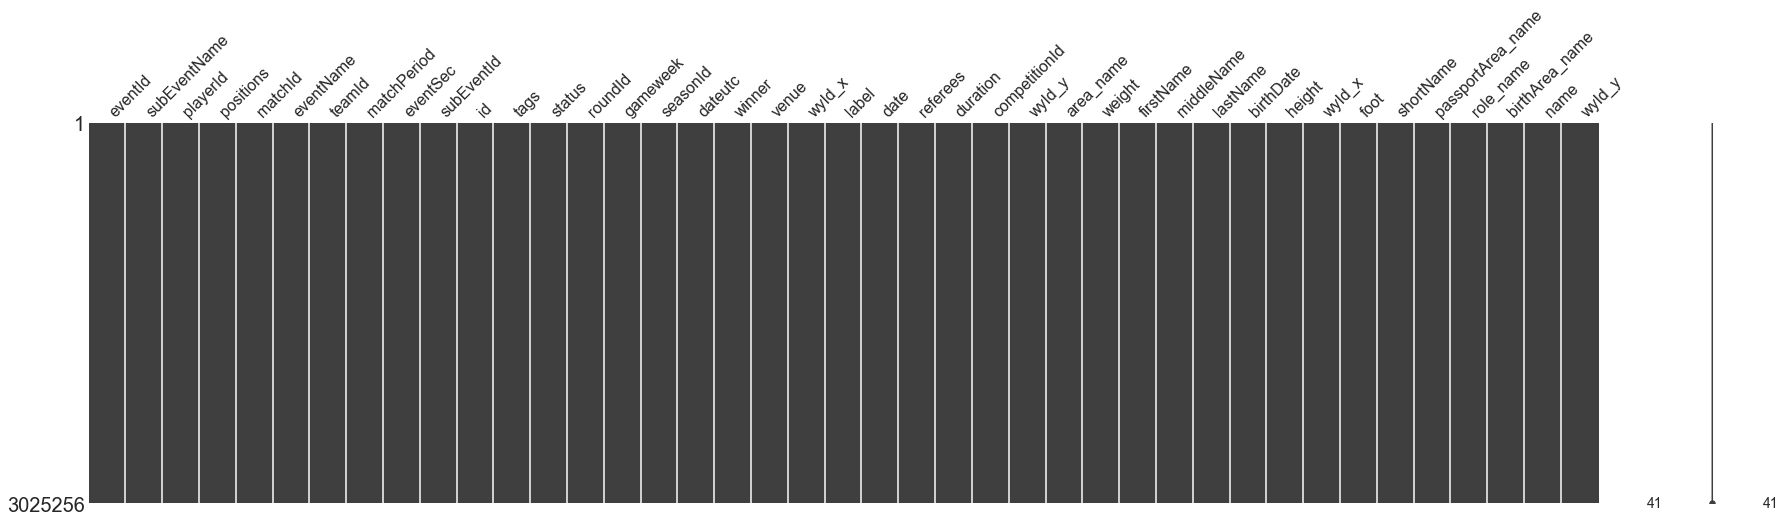

In [79]:
# Plot visualisation of the missing values for each feature of the raw DataFrame, df_wyscout_merge
msno.matrix(df_wyscout_merge, figsize = (30, 7))

In [80]:
# Counts of missing values
null_value_stats = df_wyscout_merge.isnull().sum(axis=0)
null_value_stats[null_value_stats != 0]

Series([], dtype: int64)

The visualisation shows us that there are no missing values in the DataFrame.

---

## <a id='#section4'>4. Data Engineering</a>
Before any Feature Engineering or Data Visualisation, we first need to clean and wrangle the datasets to a form that meet our needs.

### <a id='#section4.1'>4.1. Sort DataFrame</a>
Sort data by `matchId`, `matchPeriod`, and `eventSec`. Important for when determining previous events. which are attributes created for the DataFrame in the Data Engineering notebook.

In [81]:
# Sort data by matchId, matchPeriod, and eventSec
df_wyscout_merge = df_wyscout_merge.sort_values(['matchId', 'matchPeriod', 'eventSec'])

---

## <a id='#section5'>5. Export Data</a>
Export Data ready for data engineering in the subsequent notebooks.

In [82]:
# Export Shots DataFrame as CSV
if not os.path.exists(os.path.join(data_dir_wyscout, 'raw', 'csv', 'combined', 'wyscout_big5_combined.csv')):
    df_wyscout_merge.to_csv(os.path.join(data_dir_wyscout, 'raw', 'csv', 'combined', 'wyscout_big5_combined.csv'), index=None, header=True)
else:
    pass

---

## <a id='#section6'>6. Summary</a>
This notebook parses Wyscout data using [pandas](http://pandas.pydata.org/) for data manipulation through DataFrames.

---

## <a id='#section7'>7. Next Steps</a>
The step is to take the parsed dataset created in this notebook and engineer the data for new features, which is carrired out in the follow [Data Engineering](https://nbviewer.jupyter.org/github/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/Wyscout%20Data%20Engineering.ipynb) notebook. This data is then ready for use in projects including Expected Goals (xG) models and Tableau visualisations.

---

## <a id='#section8'>8. References</a>
*    Data Engineering notebook: https://nbviewer.jupyter.org/github/eddwebster/football_analytics/blob/master/notebooks/3_data_engineering/Wyscout%20Data%20Engineering.ipynb
*    Wyscout: https://wyscout.com/
*    Wyscout Events data manual: https://footballdata.wyscout.com/events-manual/
*    Pappalardo, Luca; Massucco, Emanuele (2019): Soccer match event dataset. figshare. Collection. https://doi.org/10.6084/m9.figshare.c.4415000.v5
*    Pappalardo, L., Cintia, P., Rossi, A. et al. **A public data set of spatio-temporal match events in soccer competitions**. Scientific Data 6, 236 (2019) doi:10.1038/s41597-019-0247-7, https://www.nature.com/articles/s41597-019-0247-7
*    Custom function to flatten pandas DataFrames with nested JSON column: https://stackoverflow.com/questions/39899005/how-to-flatten-a-pandas-dataframe-with-some-columns-as-json
*    WyIDs: https://support.wyscout.com/matches-wyid-events

---

## <a id='#section9'>9. Further Reading</a>

---

***Visit my website [EddWebster.com](https://www.eddwebster.com) or my [GitHub Repository](https://github.com/eddwebster) for more projects. If you'd like to get in contact, my Twitter handle is [@eddwebster](http://www.twitter.com/eddwebster) and my email is: edd.j.webster@gmail.com.***

[Back to the top](#top)